In this notebook, I've implemented the most basic version of Seq2Seq model (without attention mechanism), also know as encoder-decoder model. Most of the modeling and training part are referenced from part-I of this great tutorial series: https://github.com/bentrevett/pytorch-seq2seq.

But in this series, the preprocessed data is being used for training/evaluation (because pytorch's Multi30k class provides all the heavy lifting), so it's bit difficult to generalize the structure for custom dataset implementation. So in this notebook, I've implemented data preprocessing like tokenization, padding etc. from scratch using spacy and pure pytorch.

Here are some other references I've used:

* [Original research paper.](https://arxiv.org/pdf/1409.3215.pdf)
* [Creating custom dataset for NLP tasks](https://github.com/aladdinpersson/Machine-Learning-Collection/blob/22635a65d8cf462aa44199357928e61c0ecda000/ML/Pytorch/more_advanced/image_captioning/get_loader.py)

In [1]:
%%capture
!python -m spacy download en
!python -m spacy download de

In [2]:
import os
import re
import time
import math
import random
import unicodedata

import numpy as np
import pandas as pd

from tqdm import tqdm

import spacy

from sklearn.model_selection import train_test_split

import torch
from torch import nn, optim
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import DataLoader, Dataset

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
SEED = 28

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [4]:
data_df = pd.read_csv('../input/english-to-german/deu.txt', sep='\t', usecols=[0, 1])
data_df.columns = ['en', 'de']
data_df.head()

,en,de
0,Hi.,Hallo!
1,Hi.,Grüß Gott!
2,Run!,Lauf!
3,Run.,Lauf!
4,Wow!,Potzdonner!


In [5]:
data_df.shape

(221532, 2)

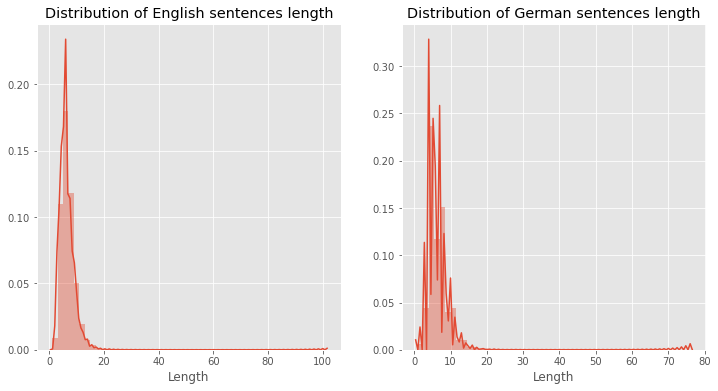

In [6]:
plt.figure(figsize=(12, 6))
plt.style.use('ggplot')
plt.subplot(1, 2, 1)
sns.distplot(data_df['en'].str.split().apply(len))
plt.title('Distribution of English sentences length')
plt.xlabel('Length')

plt.style.use('ggplot')
plt.subplot(1, 2, 2)
sns.distplot(data_df['de'].str.split().apply(len))
plt.title('Distribution of German sentences length')
plt.xlabel('Length')
plt.show()

In [7]:
seq_len_en = 20
seq_len_de = 20

In [8]:
train_df, valid_df = train_test_split(data_df, test_size=0.1, shuffle=True, random_state=28)

train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)

print(train_df.shape)
print(valid_df.shape)

(199378, 2)
(22154, 2)


In [9]:
for i in range(len(train_df)-5, len(train_df)):
    print(f'ENGLISH:\n{train_df.iloc[i]["en"]},\nGERMAN:\n{train_df.iloc[i]["de"]}\n{"="*92}')

ENGLISH:
I have the house all to myself.,
GERMAN:
Ich habe das Haus ganz für mich allein.
ENGLISH:
He lives in a big house.,
GERMAN:
Er wohnt in einem großen Haus.
ENGLISH:
This medicine tastes awful.,
GERMAN:
Diese Medizin schmeckt furchtbar.
ENGLISH:
You have to go there whether you like it or not.,
GERMAN:
Sie müssen sich dorthin begeben, ob es Ihnen gefällt oder nicht.
ENGLISH:
It's absolutely true.,
GERMAN:
Das ist die volle Wahrheit.


In [10]:
class Vocabulary:
    def __init__(self, freq_threshold=2, language='en', preprocessor=None, reverse=False):
        self.itos = {0: "<pad>", 1: "<sos>", 2: "<eos>", 3: "<unk>"}
        self.stoi = {"<pad>": 0, "<sos>": 1, "<eos>": 2, "<unk>": 3}
        self.tokenizer = spacy.load(language)
        self.freq_threshold = freq_threshold
        self.preprocessor = preprocessor
        self.reverse = reverse

    def __len__(self):
        return len(self.itos)

    def tokenize(self, text):
        if self.reverse:
            return [token.text.lower() for token in self.tokenizer.tokenizer(text)][::-1]
        else:
            return [token.text.lower() for token in self.tokenizer.tokenizer(text)]

    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = len(self.itos)

        for sentence in sentence_list:
            # Preprocess the sentence using given preprocessor.
            if self.preprocessor:
                sentence = self.preprocessor(sentence)

            for word in self.tokenize(sentence):
                if word in frequencies:
                    frequencies[word] += 1
                else:
                    frequencies[word] = 1

                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenize(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<unk>"]
            for token in tokenized_text
        ]

In [11]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.strip()
    return w

In [12]:
%%time
# Build vocab using training data
freq_threshold = 2
en_vocab = Vocabulary(freq_threshold=freq_threshold, language="en", preprocessor=preprocess_sentence, reverse=False)
de_vocab = Vocabulary(freq_threshold=freq_threshold, language="de", preprocessor=preprocess_sentence, reverse=True)

# build vocab for both english and german
en_vocab.build_vocabulary(train_df["en"].tolist())
de_vocab.build_vocabulary(train_df["de"].tolist())

CPU times: user 34.8 s, sys: 165 ms, total: 34.9 s
Wall time: 35.2 s


In [13]:
class CustomTranslationDataset(Dataset):    
    def __init__(self, df, en_vocab, de_vocab):
        super().__init__()
        self.df = df
        self.en_vocab = en_vocab
        self.de_vocab = de_vocab
        
    def __len__(self):
        return len(self.df)
    
    def _get_numericalized(self, sentence, vocab):
        """Numericalize given text using prebuilt vocab."""
        numericalized = [vocab.stoi["<sos>"]]
        numericalized.extend(vocab.numericalize(sentence))
        numericalized.append(vocab.stoi["<eos>"])
        return numericalized

    def __getitem__(self, index):
        en_numericalized = self._get_numericalized(self.df.iloc[index]["en"], self.en_vocab)
        de_numericalized = self._get_numericalized(self.df.iloc[index]["de"], self.de_vocab)

        return torch.tensor(de_numericalized), torch.tensor(en_numericalized)

In [14]:
class CustomCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        src = [item[0] for item in batch]
        src = pad_sequence(src, batch_first=False, padding_value=self.pad_idx)
        
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_idx)

        return src, targets

In [15]:
BATCH_SIZE = 256

# Define dataset and dataloader
train_dataset = CustomTranslationDataset(train_df, en_vocab, de_vocab)
valid_dataset = CustomTranslationDataset(valid_df, en_vocab, de_vocab)

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=4,
    shuffle=False,
    collate_fn=CustomCollate(pad_idx=en_vocab.stoi["<pad>"])
)

valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=BATCH_SIZE,
    num_workers=4,
    shuffle=False,
    collate_fn=CustomCollate(pad_idx=en_vocab.stoi["<pad>"])
)

In [16]:
fun_de = np.vectorize(lambda x: de_vocab.itos[x])
fun_en = np.vectorize(lambda x: en_vocab.itos[x])

In [17]:
print(f"Unique tokens in source (de) vocabulary: {len(de_vocab)}")
print(f"Unique tokens in target (en) vocabulary: {len(en_vocab)}")

Unique tokens in source (de) vocabulary: 18315
Unique tokens in target (en) vocabulary: 10655


In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

## Modeling

In [19]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hidden_dim, n_layers, dropout=0.2):
        super().__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.lstm = nn.LSTM(emb_dim, hidden_dim, n_layers, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
    
    def forward(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        outputs, (hidden_state, cell_state) = self.lstm(x)
        
        return hidden_state, cell_state

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hidden_dim, n_layers, dropout=0.2):
        super().__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.lstm = nn.LSTM(emb_dim, hidden_dim, n_layers, dropout=dropout)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x, hidden_state, cell_state):
        x = x.unsqueeze(0)
        x = self.embedding(x)
        x = self.dropout(x)
        outputs, (hidden_state, cell_state) = self.lstm(x, (hidden_state, cell_state))
        preds = self.fc(outputs.squeeze(0))
        return preds, hidden_state, cell_state

class EncoderDecoder(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        
        assert self.encoder.hidden_dim == decoder.hidden_dim
        assert self.encoder.n_layers == decoder.n_layers
    
    def forward(self, x, y, teacher_forcing_ratio=0.75):
        
        target_len = y.shape[0]
        batch_size = y.shape[1]
        target_vocab_size = self.decoder.output_dim  # Output dim
        
        outputs = torch.zeros(target_len, batch_size, target_vocab_size).to(device)
        
        # Encode the source text using encoder
        hidden_state, cell_state = self.encoder(x)
        
        # First input is <sos>
        input = y[0,:]
        
        # Decode the encoded vector using decoder
        for t in range(1, target_len):
            output, hidden_state, cell_state = self.decoder(input, hidden_state, cell_state)
            outputs[t] = output
            teacher_force = random.random() < teacher_forcing_ratio
            pred = output.argmax(1)
            input = y[t] if teacher_force else pred
        
        return outputs

In [20]:
# Initialize all models
input_dim = len(de_vocab)
output_dim = len(en_vocab)
emb_dim = 256
hidden_dim = 512
n_layers = 4
dropout = 0.4

encoder = Encoder(input_dim, emb_dim, hidden_dim, n_layers, dropout)
decoder = Decoder(output_dim, emb_dim, hidden_dim, n_layers, dropout)
model = EncoderDecoder(encoder, decoder).to(device)

In [21]:
# Initialized weights as defined in paper
def init_weights(m):
    for name, param in m.named_parameters():
        nn.init.uniform_(param.data, -0.08, 0.08)
        
model.apply(init_weights)

EncoderDecoder(
  (encoder): Encoder(
    (embedding): Embedding(18315, 256)
    (lstm): LSTM(256, 512, num_layers=4, dropout=0.4)
    (dropout): Dropout(p=0.4, inplace=False)
  )
  (decoder): Decoder(
    (embedding): Embedding(10655, 256)
    (lstm): LSTM(256, 512, num_layers=4, dropout=0.4)
    (dropout): Dropout(p=0.4, inplace=False)
    (fc): Linear(in_features=512, out_features=10655, bias=True)
  )
)

In [22]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 28,643,743 trainable parameters


In [23]:
optimizer = optim.Adam(model.parameters())
criterion = nn.CrossEntropyLoss(ignore_index=en_vocab.stoi["<pad>"])

In [24]:
def train(model, iterator, optimizer, criterion, clip):
    model.train()
    epoch_loss = 0
    
    for i, batch in tqdm(enumerate(iterator), total=len(iterator), position=0, leave=True):
        src = batch[0].to(device)
        trg = batch[1].to(device)

        optimizer.zero_grad()
        
        output = model(src, trg)
        
        #trg = [trg len, batch size]
        #output = [trg len, batch size, output dim]
        
        output_dim = output.shape[-1]
        output = output[1:].view(-1, output_dim)
        trg = trg[1:].view(-1)
        
        #trg = [(trg len - 1) * batch size]
        #output = [(trg len - 1) * batch size, output dim]
        
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [25]:
def evaluate(model, iterator, criterion):
    model.eval()    
    epoch_loss = 0

    with torch.no_grad():
        for i, batch in tqdm(enumerate(iterator), total=len(iterator), position=0, leave=True):
            src = batch[0].to(device)
            trg = batch[1].to(device)

            output = model(src, trg, 0) #turn off teacher forcing

            #trg = [trg len, batch size]
            #output = [trg len, batch size, output dim]

            output_dim = output.shape[-1]
            output = output[1:].view(-1, output_dim)
            trg = trg[1:].view(-1)

            #trg = [(trg len - 1) * batch size]
            #output = [(trg len - 1) * batch size, output dim]

            loss = criterion(output, trg)
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [26]:
def inference(model, sentence):
    model.eval()
    result = []

    with torch.no_grad():
        sentence = sentence.to(device)
        
        hidden_state, cell_state = model.encoder(sentence)

        # First input to decoder is "<sos>"
        inp = torch.tensor([en_vocab.stoi["<sos>"]]).to(device)

        # Decode the encoded vector using decoder until max length is reached or <eos> is generated.
        for t in range(1, seq_len_en):
            output, hidden_state, cell_state = model.decoder(inp, hidden_state, cell_state)
            pred = output.argmax(1)
            if pred == en_vocab.stoi["<eos>"]:
                break
            result.append(en_vocab.itos[pred.item()])
            inp = pred
            
    return " ".join(result)

In [27]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [28]:
for sample_batch in valid_loader:
    break

In [29]:
N_EPOCHS = 12
CLIP = 1

best_valid_loss = float('inf')

sample_source = ' '.join([word for word in fun_de(sample_batch[0][:, 101]) if word not in ["<pad>", "<sos>", "<eos>"]])
sample_target = ' '.join([word for word in fun_en(sample_batch[1][:, 101]) if word not in ["<pad>", "<sos>", "<eos>"]])

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_loader, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_loader, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'best_model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\t Train Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    print(f'\t Sample Source (German): {sample_source}')
    print(f'\t Sample Target (English): {sample_target}')
    print(f'\t Generated: {inference(model, sample_batch[0][:, 101].reshape(-1, 1))}\n')

100%|██████████| 87/87 [00:26<00:00,  3.22it/s]


Epoch: 01 | Time: 6m 35s
	 Train Loss: 4.530 | Train PPL:  92.759
	 Val. Loss: 4.697 |  Val. PPL: 109.649
	 Sample Source (German): ? sind kinder deine wo , du <unk>
	 Sample Target (English): do you know where your children are ?
	 Generated: do you have to to do that ?



100%|██████████| 87/87 [00:27<00:00,  3.18it/s]


Epoch: 02 | Time: 6m 39s
	 Train Loss: 3.556 | Train PPL:  35.031
	 Val. Loss: 4.164 |  Val. PPL:  64.348
	 Sample Source (German): ? sind kinder deine wo , du <unk>
	 Sample Target (English): do you know where your children are ?
	 Generated: do you have to go to boston ?



100%|██████████| 87/87 [00:28<00:00,  3.03it/s]


Epoch: 03 | Time: 6m 43s
	 Train Loss: 3.067 | Train PPL:  21.471
	 Val. Loss: 3.933 |  Val. PPL:  51.042
	 Sample Source (German): ? sind kinder deine wo , du <unk>
	 Sample Target (English): do you know where your children are ?
	 Generated: do you know where to play a ? ?



100%|██████████| 87/87 [00:29<00:00,  2.99it/s]


Epoch: 04 | Time: 6m 45s
	 Train Loss: 2.698 | Train PPL:  14.857
	 Val. Loss: 3.586 |  Val. PPL:  36.079
	 Sample Source (German): ? sind kinder deine wo , du <unk>
	 Sample Target (English): do you know where your children are ?
	 Generated: do you know where you <unk> been ?



100%|██████████| 87/87 [00:28<00:00,  3.07it/s]


Epoch: 05 | Time: 6m 46s
	 Train Loss: 2.396 | Train PPL:  10.975
	 Val. Loss: 3.448 |  Val. PPL:  31.433
	 Sample Source (German): ? sind kinder deine wo , du <unk>
	 Sample Target (English): do you know where your children are ?
	 Generated: do you know what you <unk> last ?



100%|██████████| 87/87 [00:28<00:00,  3.05it/s]


Epoch: 06 | Time: 6m 48s
	 Train Loss: 2.165 | Train PPL:   8.713
	 Val. Loss: 3.282 |  Val. PPL:  26.629
	 Sample Source (German): ? sind kinder deine wo , du <unk>
	 Sample Target (English): do you know where your children are ?
	 Generated: do you know where you <unk> kids ?



100%|██████████| 87/87 [00:28<00:00,  3.01it/s]


Epoch: 07 | Time: 6m 50s
	 Train Loss: 1.992 | Train PPL:   7.330
	 Val. Loss: 3.073 |  Val. PPL:  21.612
	 Sample Source (German): ? sind kinder deine wo , du <unk>
	 Sample Target (English): do you know where your children are ?
	 Generated: do you know where you are kids ?



100%|██████████| 87/87 [00:30<00:00,  2.86it/s]


Epoch: 08 | Time: 6m 53s
	 Train Loss: 1.841 | Train PPL:   6.302
	 Val. Loss: 3.021 |  Val. PPL:  20.511
	 Sample Source (German): ? sind kinder deine wo , du <unk>
	 Sample Target (English): do you know where your children are ?
	 Generated: do you know where you are kids ?



100%|██████████| 87/87 [00:28<00:00,  3.02it/s]


Epoch: 09 | Time: 6m 53s
	 Train Loss: 1.705 | Train PPL:   5.499
	 Val. Loss: 2.928 |  Val. PPL:  18.683
	 Sample Source (German): ? sind kinder deine wo , du <unk>
	 Sample Target (English): do you know where your children are ?
	 Generated: do you know where your children are ?



100%|██████████| 87/87 [00:30<00:00,  2.85it/s]


Epoch: 10 | Time: 6m 58s
	 Train Loss: 1.606 | Train PPL:   4.984
	 Val. Loss: 2.875 |  Val. PPL:  17.729
	 Sample Source (German): ? sind kinder deine wo , du <unk>
	 Sample Target (English): do you know where your children are ?
	 Generated: do you know where your children are ?



100%|██████████| 87/87 [00:30<00:00,  2.83it/s]


Epoch: 11 | Time: 6m 52s
	 Train Loss: 1.511 | Train PPL:   4.531
	 Val. Loss: 2.844 |  Val. PPL:  17.184
	 Sample Source (German): ? sind kinder deine wo , du <unk>
	 Sample Target (English): do you know where your children are ?
	 Generated: do you know where your children are ?



100%|██████████| 87/87 [00:29<00:00,  2.97it/s]


Epoch: 12 | Time: 6m 55s
	 Train Loss: 1.442 | Train PPL:   4.228
	 Val. Loss: 2.800 |  Val. PPL:  16.440
	 Sample Source (German): ? sind kinder deine wo , du <unk>
	 Sample Target (English): do you know where your children are ?
	 Generated: do you know where they are kids ?



In [30]:
# Load the best model.
model_path = "./best_model.pt"
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>

## Results

In [31]:
for idx in range(20):
    print(f'ACTUAL GERMAN: {" ".join([word for word in fun_de(sample_batch[0][:, idx]) if word not in ["<pad>", "<sos>", "<eos>"]])}')
    print(f'ACTUAL: ENGLISH: {" ".join([word for word in fun_en(sample_batch[1][:, idx]) if word not in ["<pad>", "<sos>", "<eos>"]])}')
    print(f'GENERATED BY MODEL: {inference(model, sample_batch[0][:, idx].reshape(-1, 1))}')
    print("="*92)

ACTUAL GERMAN: . tisch einem an sitzt tom
ACTUAL: ENGLISH: tom is sitting at a table .
GENERATED BY MODEL: tom is sitting in a table .
ACTUAL GERMAN: . bitte , lauter sprich
ACTUAL: ENGLISH: please speak more loudly .
GENERATED BY MODEL: speak louder , please .
ACTUAL GERMAN: . aufzupassen kinder toms auf , helfen mir musst du
ACTUAL: ENGLISH: i need you to help me take care of tom <unk> kids .
GENERATED BY MODEL: you need to help me with the children .
ACTUAL GERMAN: ? das du brauchst <unk>
ACTUAL: ENGLISH: what do you need that for ?
GENERATED BY MODEL: what do you need this for ?
ACTUAL GERMAN: . sich langweile er , sagte tom
ACTUAL: ENGLISH: tom said that he <unk> bored .
GENERATED BY MODEL: tom said he was bored .
ACTUAL GERMAN: . angekommen sonne der mit aber , gegangen regen dem mit sind wir
ACTUAL: ENGLISH: it was sunny when we arrived , but rainy when we left .
GENERATED BY MODEL: we went to the mountains , but the rain was closed .
ACTUAL GERMAN: . unbeholfen ist sie
ACTUAL: 

As you can see, this works well on short sentences.